In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib as plt
from matplotlib import pyplot as plt
from pathlib import Path
from random import randint

plt.rcParams["figure.figsize"] = (20,15)

In [2]:
print(cv2.__version__)

4.0.0


In [3]:
# Questionnare Metadata
num_choices = 4
num_questions = 8

In [148]:
# Input Structure
img_dir = "./test_box/"
img_index = 6
img_file_name = []

entries = Path(img_dir)
for entry in entries.iterdir():
    img_file_name.append(entry.name)
    #print(entry.name)

In [149]:
img_file_name

['Photo on 12-7-21 at 23.23.jpg',
 'Photo on 12-7-21 at 23.22.jpg',
 'Photo on 12-7-21 at 23.40.jpg',
 'Photo on 12-7-21 at 23.39.jpg',
 'Photo on 12-7-21 at 23.23 #2.jpg',
 'Photo on 12-7-21 at 23.28.jpg',
 'Photo on 12-8-21 at 00.08.jpg']

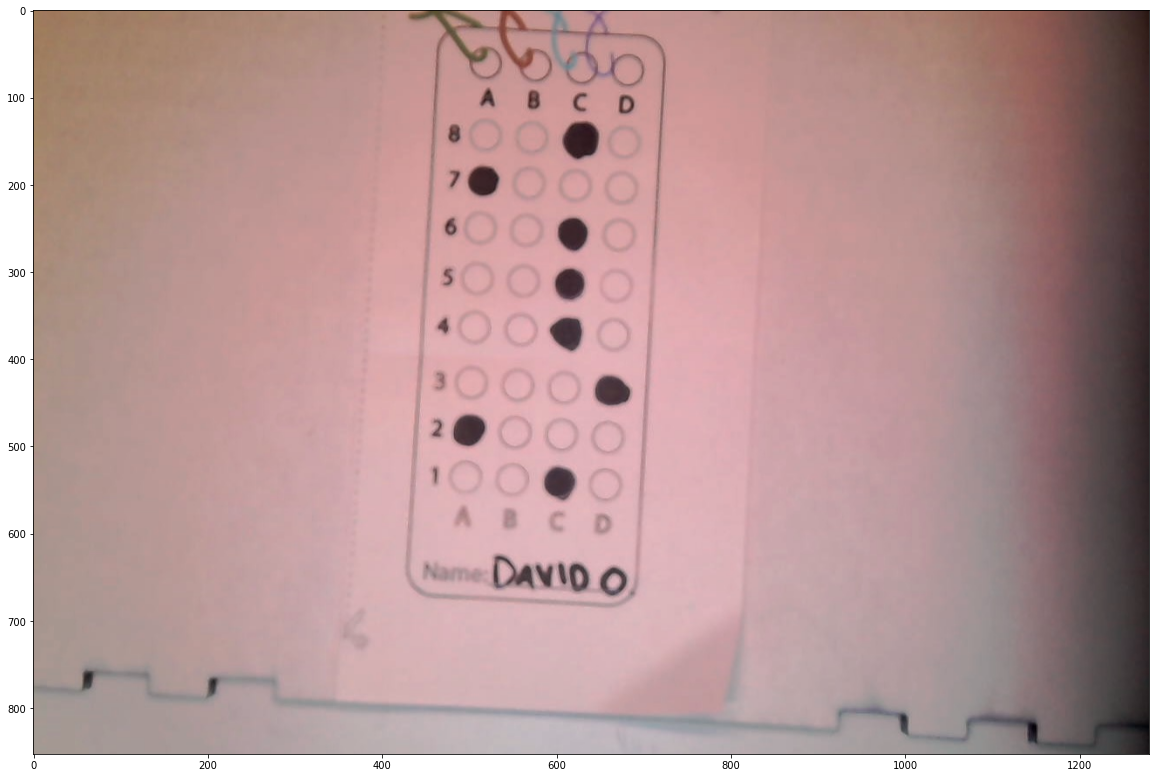

In [152]:
# load the image
#image = cv2.rotate(img_dir + img_file_name[img_index], cv2.ROTATE_90_CLOCKWISE)
image = cv2.imread(img_dir + img_file_name[img_index])

#image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(image)

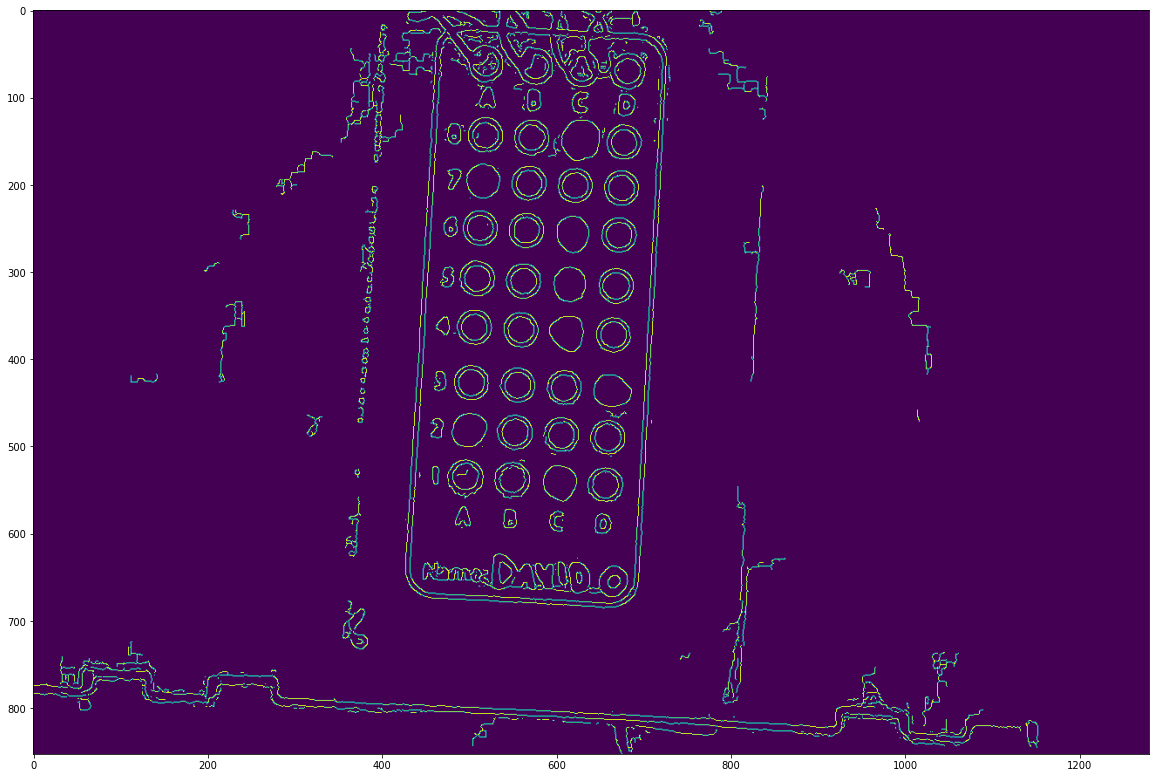

In [153]:
# grayscale, blur, edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_img_eqhist=cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(gray_img_eqhist, (5, 5), 0)
edged = cv2.Canny(blurred, 5, 60)
thresh = cv2.threshold(edged, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

plt.imshow(edged)

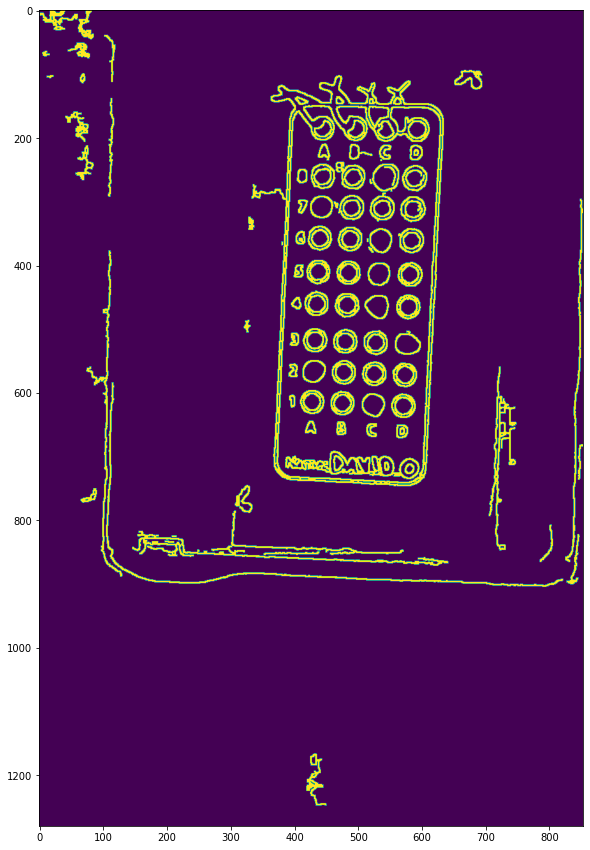

In [135]:
kernel = np.ones((3,3),np.uint8)
#erosion = cv2.erode(edged,kernel,iterations = 2)
#dilation = cv2.dilate(edged,kernel,iterations = 1)
#closing = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

#edged_closed = edged.copy() | closing
plt.imshow(dilation)

In [140]:
# Apply Hough transform on the blurred image.
detected_circles = cv2.HoughCircles(blurred, 
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
               param2 = 30, minRadius = 10, maxRadius = 40)
  
# Draw circles that are detected.
if detected_circles is not None:
  
    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(rnp.around(detected_circles))
  
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
  
        # Draw the circumference of the circle.
        cv2.circle(image, (a, b), r, (0, 255, 0), 2)
  
        # Draw a small circle (of radius 1) to show the center.
        cv2.circle(image, (a, b), 1, (0, 0, 255), 3)
        cv2.imshow("Detected Circle", image)
        cv2.waitKey(0)

NameError: name 'rnp' is not defined

442


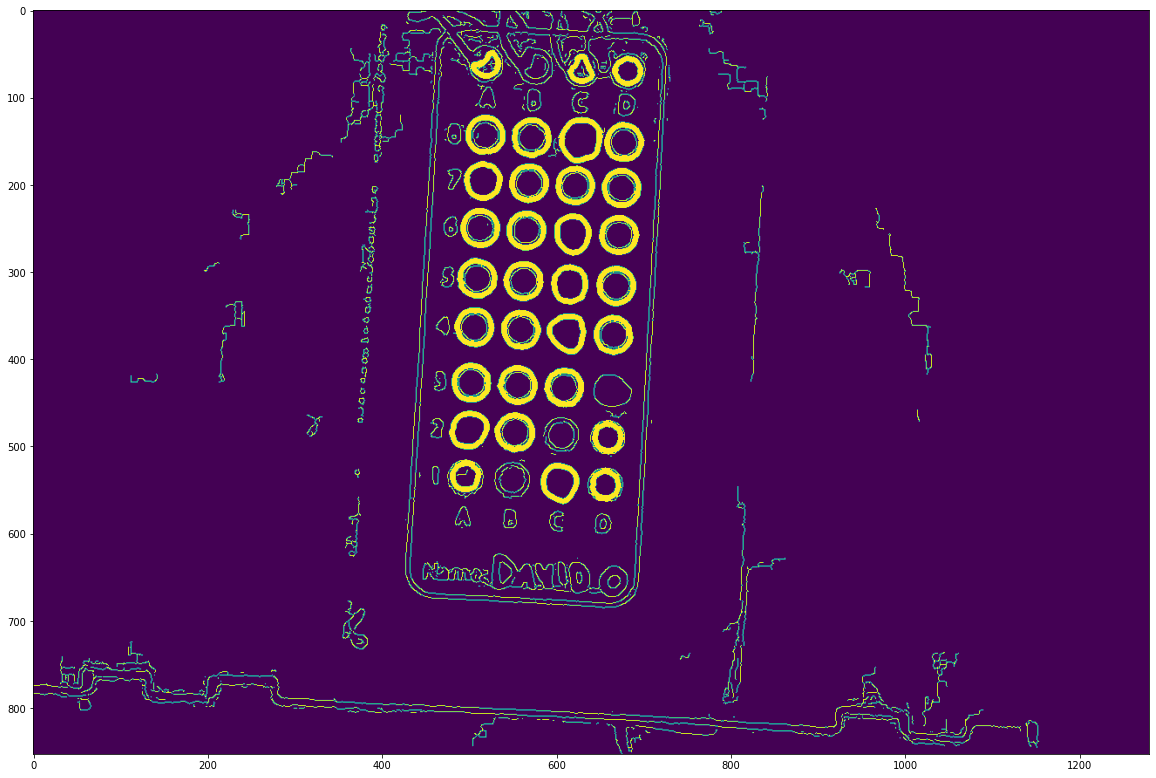

In [162]:
# find contours in the edge map, then initialize
# the contour that corresponds to the document
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

image2 = edged.copy()
cnt = contours
#cv2.drawContours(image2, contours, -1, (255,0,0), 3)
#plt.imshow(image2)

circle_x = []
circle_y = []
questionCnts = []

for c in contours:

    #---- making sure to avoid small unwanted contours ---
    if cv2.contourArea(c) > 100:
        epsilon = cv2.arcLength(c, True)
        approximations = cv2.approxPolyDP(c, 0.04 * epsilon, True)
        area = cv2.contourArea(c)
        
        #--- selecting contours having more than 2 sides ---
        if  4 <= len(approximations) and area > 400 and area < 50000:
            (x, y, w, h) = cv2.boundingRect(c)
            ar = w / float(h)
            
            # in order to label the contour as a question, region
            # should be sufficiently wide, sufficiently tall, and
            # have an aspect ratio approximately equal to 1
            if w >= 20 and h >= 20 and ar >= 0.85 and ar <= 1.15:
                questionCnts.append(c)
            
                #(x,y),radius = cv2.minEnclosingCircle(c)
                #x, y, w, h = cv2.boundingRect(c)
                #print(x, y)
            
            circle_x.append(x)
            circle_y.append(y)

cv2.drawContours(image2, questionCnts, -1, (255, 0, 0), 5)
plt.imshow(image2)

In [143]:
def sort_contours(cnts, method):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

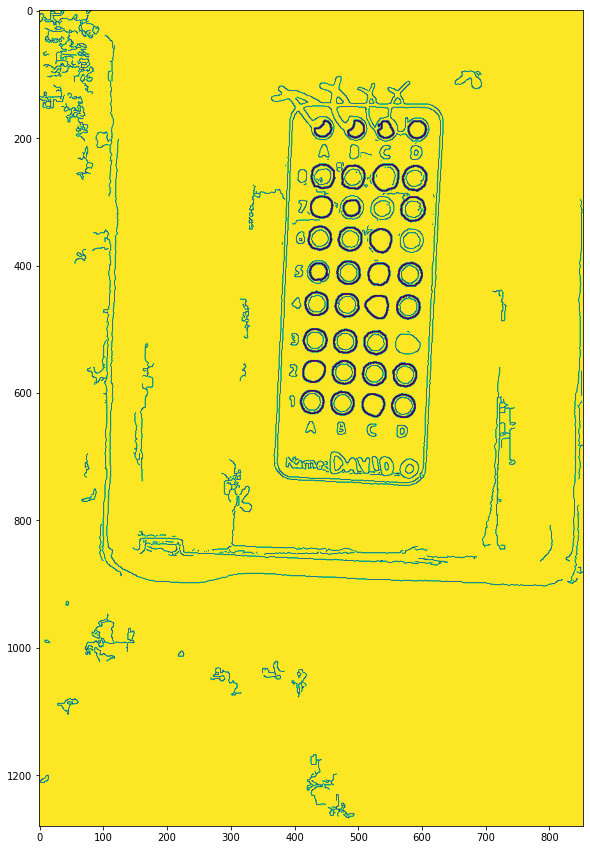

In [145]:
# Sort question circles from top to bottom 
questionCnts = sort_contours(questionCnts, "top-to-bottom")[0]

thresh_img = thresh.copy()
cv2.drawContours(thresh_img, questionCnts, -1, (0, 0, 0), 2)
plt.imshow(thresh_img)

(1094, 1)
(1105, 0)
(1109, 2)
(1056, 2)
(1107, 2)
(1029, 0)
(1505, 2)
(1035, 0)


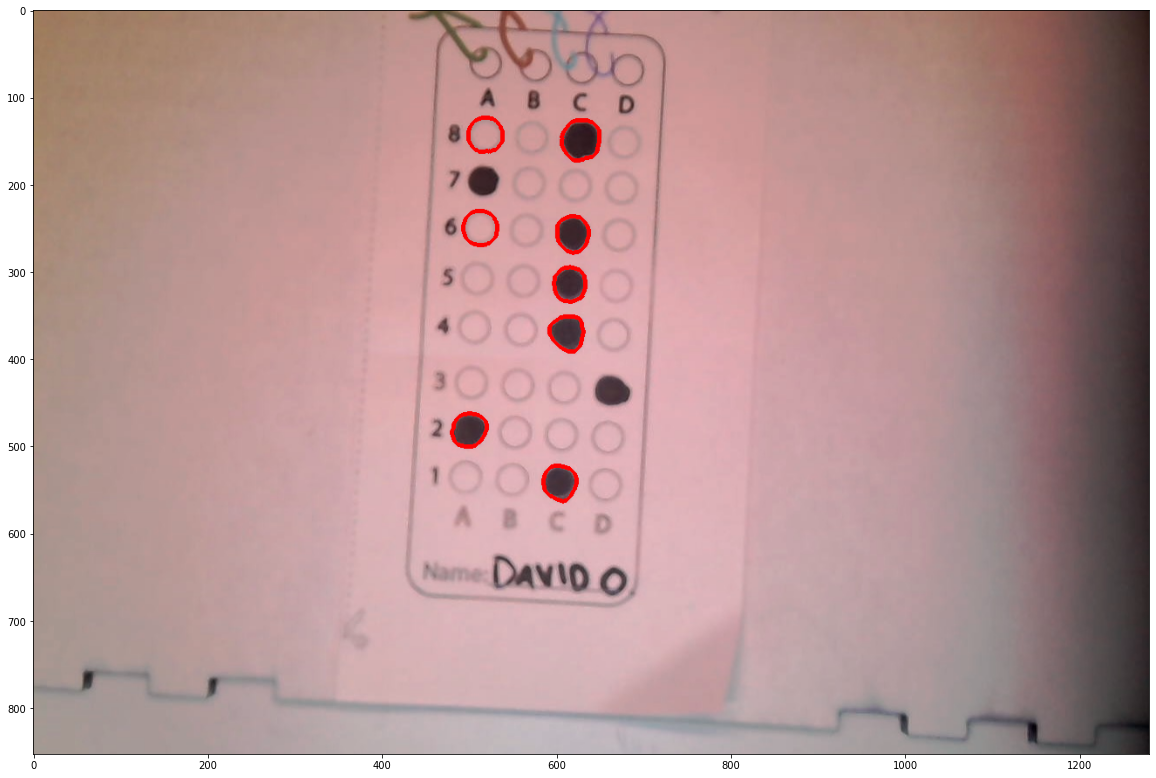

In [163]:
image3 = image.copy()

# Output Structure
circled_answer = []

for (q, i) in enumerate(np.arange(0, len(questionCnts), num_choices)):
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    cnts = sort_contours(questionCnts[i:i + num_choices], "left-to-right")[0]
    #print(cnts_tmp)
    bubbled = None
    
#     cv2.drawContours(image3, cnts, -1, 255, -1)
#     plt.imshow(image3)

    
    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        #print("j: " + str(j))
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
    
        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
        #print(total)
        
        # if the current total has a larger number of total
        # non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total > bubbled[0]:
#             print("updated bubbled")
#             print(total)
#             print(j)
            
            bubbled = (total, j)
            #print(len(bubbled))
    print(bubbled)
    circled_answer.append(bubbled[1])
    cv2.drawContours(image3, [cnts[bubbled[1]]], -1, (255, 0, 0), 3)
    plt.imshow(image3)

In [41]:
print(circled_answer)

[1, 1, 2, 0, 2, 2, 3, 1]


In [61]:
bubbled

(638, 3)

In [24]:
randint(0, 3)

0

In [33]:
def response_safeguard(response):
    
    #check for too little recognized things
    while len(response) < num_questions:
        response.append(randint(0, num_choices))
        
    #check for too many recognized things
    if len(response) > num_questions:
        response = response[:8]
    
    
    return response

In [36]:
response = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

response_safe = response_safeguard(response)

In [37]:
print(response_safe)

[0, 0, 0, 0, 0, 0, 0, 0]


# Draft

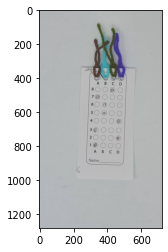

In [57]:
# im2, contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
# 	cv2.CHAIN_APPROX_SIMPLE)
# #cnts = imutils.grab_contours(contours)
# docCnt = None
# # ensure that at least one contour was found
# if len(contours) > 0:
#     # sort the contours according to their size in
# 	# descending order
# 	cnts = sorted(contours, key=cv2.contourArea, reverse=True)
# 	# loop over the sorted contours
# 	for c in cnts:
# 		# approximate the contour
# 		peri = cv2.arcLength(c, True)
# 		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
# 		# if our approximated contour has four points,
# 		# then we can assume we have found the paper
# 		if len(approx) == 4:
# 			docCnt = approx
# 			break

# image3 = image.copy()
# cv2.drawContours(image3, docCnt, -1, (255, 0, 0), 2)
# plt.imshow(image3)

In [31]:
# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

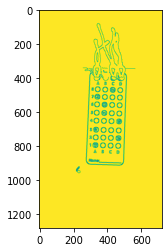

In [11]:
plt.imshow(thresh)